In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import tensorboard as tb
sns.set_theme()

In [2]:
reward_df = pd.read_csv('sac_reward_train.csv')
# time_df = pd.read_csv('ppo_step_time_train.csv')

In [3]:
reward_df['Step'] = reward_df['Step'] - 2 

In [4]:
n = 10
reward_df[f'Running_{n}'] = reward_df['Step'] // n

In [5]:
reward_std = reward_df['Value'].rolling(n).std()
reward_df[f'mean_{n}'] = reward_df['Value'].rolling(n).mean()
reward_df['lower_std'] = reward_df[f'mean_{n}'] - reward_std
reward_df['upper_std'] = reward_df[f'mean_{n}'] + reward_std
reward_df['Wall time'] = pd.to_datetime(reward_df['Wall time'], unit='s')
reward_df['Relative time'] = reward_df['Wall time'] - reward_df['Wall time'][0]

In [6]:
alpha=0.1
reward_df['Value_ema'] = reward_df['Value'].ewm(alpha=alpha).mean()

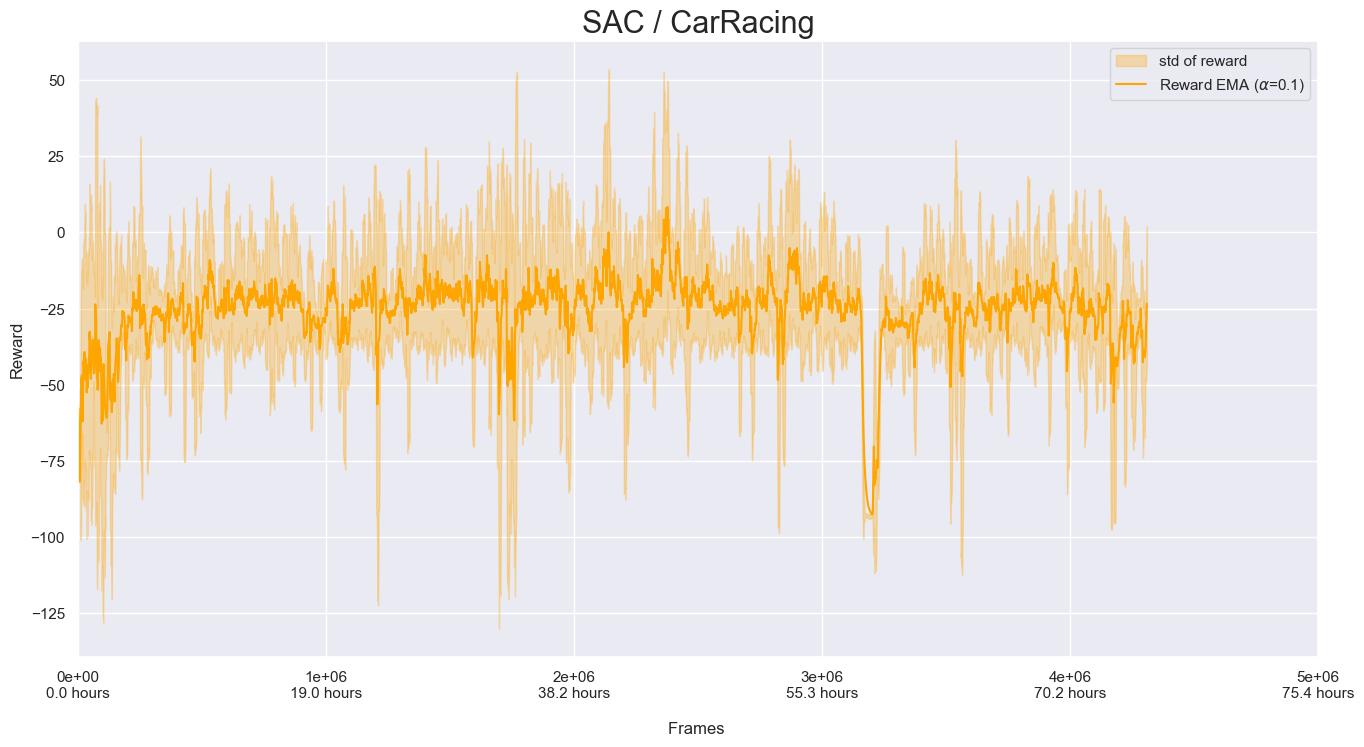

In [13]:
line_color = 'orange'
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('SAC / CarRacing', fontdict={'fontsize':22})
ax.set_ylabel('Reward')
ax.set_xlabel('Frames ')
ax.set_xlim(xmin=0,xmax=5e6)
ax.fill_between(reward_df['Steps accum.'], reward_df['lower_std'], reward_df['upper_std'], alpha=.3, color=line_color, label='std of reward')
sns.lineplot(x=reward_df['Steps accum.'], y=reward_df['Value_ema'], label='Reward EMA '+ r'($\alpha$={0})'.format(alpha), color=line_color)
# ax.plot(reward_df['Value_ema'], color=line_color, label=f'Reward EMA (alpha={alpha})')
new_ticks = []
for x in ax.get_xticks().tolist():
    # txt = str(int(x//1e6))
    txt = int(x)
    if x >= 0:
        nearest_idx = min(reward_df['Steps accum.'].searchsorted(x), len(reward_df)-1)
        hours = reward_df['Relative time'].iloc[nearest_idx].total_seconds()/3600
        txt = f"{txt:.0e}" + '\n' + f"{hours:.1f}" + ' hours\n'
    new_ticks.append(txt)
ax.set_xticks(ax.get_xticks().tolist())
ax.set_xticklabels(new_ticks)
ax.legend()
plt.show()

In [11]:
ax.get_xticklabels()

[Text(0.0, 0, '0\n0.0 hours\n'),
 Text(2000000.0, 0, '2\n9.2 hours\n'),
 Text(4000000.0, 0, '4\n18.4 hours\n'),
 Text(6000000.0, 0, '6\n27.6 hours\n'),
 Text(8000000.0, 0, '8\n36.9 hours\n'),
 Text(10000000.0, 0, '10\n46.1 hours\n'),
 Text(12000000.0, 0, '12\n47.2 hours\n')]

In [89]:
new_ticks = []
for x in ax.get_xticks().tolist():
    txt = str(int(x//1e6))
    if x >= 0:
        nearest_idx = min(reward_df['Steps accum.'].searchsorted(x), len(reward_df)-1)
        hours = reward_df['Relative time'].iloc[nearest_idx].total_seconds()//3600
        txt = txt + '\n' + str(hours) + ' hours'
    new_ticks.append(txt)

In [88]:
new_ticks

['-2',
 '0\n0.0 hours',
 '2\n9.0 hours',
 '4\n18.0 hours',
 '6\n27.0 hours',
 '8\n36.0 hours',
 '10\n46.0 hours',
 '12\n47.0 hours']

In [78]:
reward_df['Relative time'].iloc[107].total_seconds()//3600

0.0

In [72]:
reward_df['Steps accum.'][107]

20010.0

In [200]:
new_ticks = []
for tick in ax.get_xticklabels():
    x,y = tick.get_position()
    if 0 <= x <= len(reward_df):
        hours = int(reward_df['Relative time'][x].total_seconds()//3600)
        old_txt = tick.get_text()
        tick.set_text(old_txt + '\n' + str(hours) + ' hours')
    new_ticks.append(tick)

In [202]:
new_tick_labels

['−5000',
 '0\n0 hours\n0 hours',
 '5000\n9 hours\n9 hours',
 '10000\n14 hours\n14 hours',
 '15000\n17 hours\n17 hours',
 '20000\n20 hours\n20 hours',
 '25000\n25 hours\n25 hours',
 '30000\n30 hours\n30 hours',
 '35000\n33 hours\n33 hours',
 '40000']

In [8]:
df_ep_steps = pd.read_csv('sac_episode_steps.csv')
# df_ep_steps['Steps'] = df_ep_steps['Value']
df_ep_steps['Steps accum.'] = df_ep_steps['Value'].cumsum()

In [9]:
df_ep_steps['Steps accum.']

0          1000.0
1          2000.0
2          3000.0
3          3615.0
4          4615.0
          ...    
4336    4305537.0
4337    4306537.0
4338    4307537.0
4339    4308537.0
4340    4309537.0
Name: Steps accum., Length: 4341, dtype: float64

In [10]:
reward_df['Steps accum.'] = df_ep_steps['Steps accum.']

In [11]:
df_ep_steps['Steps'].describe()

KeyError: 'Steps'

In [ ]:
step_size = 50_000
df_ep_steps['Step mark'] = None
for i, acc_step in enumerate(df_ep_steps['Steps accum.']):
    df_ep_steps['Step mark'] = 